## Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Import libraries

In [1]:
!pip install Augmentor

In [2]:
import pathlib
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Rescaling, RandomFlip, RandomZoom, RandomRotation, BatchNormalization
import pandas as pd
import pathlib
import Augmentor
import os
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Define some utilities function

In [3]:
# load image dataset

def load_image_dataset(dir_path, subset, label_mode, img_height=180, img_width=180, batch_size=32, validation_split=0.2):
  return image_dataset_from_directory(
    dir_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode=label_mode,
    subset=subset,
    seed=100,
    validation_split=validation_split
)

In [4]:
# load image data generator

def load_image_data_generator(dir_path, img_height=180, img_width=180, batch_size=32):
  data_generator = ImageDataGenerator(rescale=1.0/255.0)
  return data_generator.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=100
)

In [5]:
# get class distribution

def get_class_distribution(dir_path, idx_to_class_map, consider_augment_dir = False):
  class_names = list(idx_to_class_map.values())
  image_counts = [0]*len(class_names)
  img_dir_path = pathlib.Path(dir_path)

  for i in range(0, len(class_names)):
    image_counts[i] = len(list(img_dir_path.glob(class_names[i] +'/*.jpg')))

    if consider_augment_dir == True:
      directory_out = dir_path + '/' + class_names[i] + '/output/'
      class_directory_out = pathlib.Path(directory_out)
      image_counts[i] += len(list(class_directory_out.glob('*.jpg')))

  class_distibution = pd.DataFrame({
      'Class Name': class_names,
      'Number of Images': image_counts
  })

  return class_distibution

## Data Reading/Data Understanding

In [6]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# define path for data reading

base_path = '/content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration'
train_dir = base_path + '/Train'
test_dir = base_path + '/Test'

In [8]:
print('Train directory path:', train_dir)
print('Test directory path:', test_dir)

Train directory path: /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Test directory path: /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test


## Dataset creation

In [9]:
# set parameters for the data loade

img_height = 180
img_width = 180
batch_size = 32

In [10]:
# read train data from train directory

train_data = load_image_dataset(train_dir, 'training', 'categorical')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
# read validation data from train directory

validation_data = load_image_dataset(train_dir, 'validation', 'categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# load test images

test_data = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    seed=100
)

Found 120 files belonging to 9 classes.


## Dataset visualisation

In [14]:
# load image dataset for visualisation

image_data_set = load_image_data_generator(train_dir)

Found 2239 images belonging to 9 classes.


In [15]:
# extract class name from class index

class_indices = image_data_set.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
idx_to_class

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

In [16]:
# extract image for each of the class

class_images = {}

while len(class_images) < 9:
  images, labels = next(image_data_set)
  for i in range(0, len(labels)):
    label = labels[i].argmax(axis=0)
    if label not in class_images:
      class_images[label] = images[i]

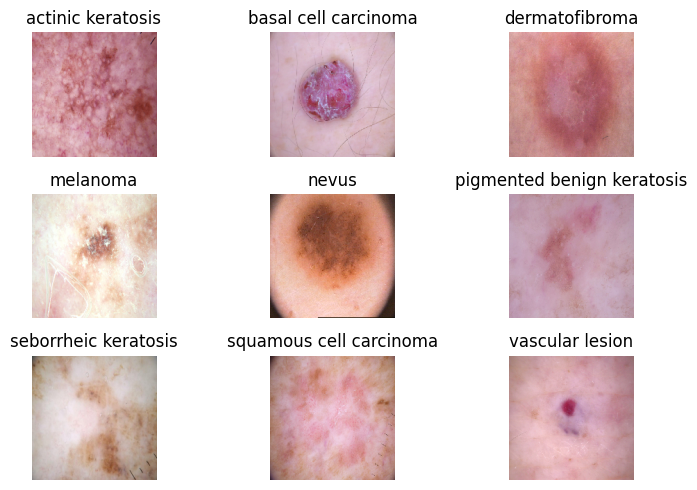

In [17]:
# create a grid for plotting
fig, axes = plt.subplots(3, 3, figsize=(8,5))

# create images
images = [0]*9

for label, image in class_images.items():
  images[int(label)] = image

# plot images
for i, ax in enumerate(axes.flat):
  if i < len(images):
    ax.imshow(images[i])
    ax.set_title(idx_to_class[i])
  ax.axis('off')

plt.tight_layout()

## Model building & training

In [25]:
# create the NN model
model1 = Sequential()

model1.add(Rescaling(1./255,input_shape=(180,180,3)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPool2D())

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPool2D())

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPool2D())

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPool2D())
model1.add(Dropout(0.5))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(9, activation='softmax'))

# define callbacks for model
checkpoint = ModelCheckpoint('model1.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
non_converge_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

# compile the model
model1.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)      

In [26]:
# train the model

model1.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[checkpoint, non_converge_stop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0450 - accuracy: 0.2126
Epoch 1: val_accuracy improved from -inf to 0.28188, saving model to model1.h5
56/56 [==============================] - 17s 267ms/step - loss: 2.0450 - accuracy: 0.2126 - val_loss: 1.9162 - val_accuracy: 0.2819
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.8778 - accuracy: 0.2946
Epoch 2: val_accuracy improved from 0.28188 to 0.29754, saving model to model1.h5
56/56 [==============================] - 16s 265ms/step - loss: 1.8778 - accuracy: 0.2946 - val_loss: 1.8426 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.7934 - accuracy: 0.3387
Epoch 3: val_accuracy improved from 0.29754 to 0.30649, saving model to model1.h5
56/56 [==============================] - 16s 266ms/step - loss: 1.7934 - accuracy: 0.3387 - val_loss: 1.8555 - val_accuracy: 0.3065
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.7323 - ac

In [27]:
# evaluate model1 performance on test images

best_model1 = load_model('model1.h5')
_, acc = best_model1.evaluate(test_data)
print('Accuracy on test images from model1:', round(acc, 4))

4/4 [==============================] - 1s 53ms/step - loss: 2.0673 - accuracy: 0.3833
Accuracy on test images from model1: 0.3833


## Findings

- Best Train accuracy: 56.42%
- Best Validation accuracy: 53.24%
- Best Test accuracy: 38.33%
- Model is underfitting.
- Let's try some data augmentation strategy like rotation, zoom and flip to reduce underfitting.


## Model building & training on the augmented data

In [28]:
# create the NN model
model2 = Sequential()

# data augmentation strategy to resolve underfitting/overfitting
model2.add(RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)))
model2.add(RandomRotation(0.2, fill_mode='reflect'))

model2.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))

model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D())

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D())

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D())

model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(MaxPool2D())
model2.add(Dropout(0.5))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(9, activation='softmax'))

# compile the model
model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# define callbacks for model
checkpoint = ModelCheckpoint('model2.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
non_converge_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)       

In [29]:
# train the model

model2.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[checkpoint, non_converge_stop])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0720 - accuracy: 0.2121
Epoch 1: val_accuracy improved from -inf to 0.29083, saving model to model2.h5
56/56 [==============================] - 19s 309ms/step - loss: 2.0720 - accuracy: 0.2121 - val_loss: 1.9430 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.8385 - accuracy: 0.3253
Epoch 2: val_accuracy improved from 0.29083 to 0.33557, saving model to model2.h5
56/56 [==============================] - 18s 309ms/step - loss: 1.8385 - accuracy: 0.3253 - val_loss: 1.7544 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.7382 - accuracy: 0.3772
Epoch 3: val_accuracy did not improve from 0.33557
56/56 [==============================] - 18s 306ms/step - loss: 1.7382 - accuracy: 0.3772 - val_loss: 1.7818 - val_accuracy: 0.3333
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.6660 - accuracy: 0.4096
Epoch 4: val_acc

In [31]:
# evaluate model2 performance on test images

best_model2 = load_model('model2.h5')
_, acc = best_model2.evaluate(test_data)
print('Accuracy on test images from model2:', round(acc, 4))

4/4 [==============================] - 1s 53ms/step - loss: 2.1285 - accuracy: 0.3583
Accuracy on test images from model2: 0.3583


## Findings

- Best Train accuracy: 52.51%
- Best Validation accuracy: 53.69%
- Best Test accuracy: 35.83%
- After performing data augmentation the model is still underfitting.
- Let's try to check and handle class imbalance to optimize the performance.

## Class distribution

In [32]:
# images in each classes

get_class_distribution(train_dir, idx_to_class)

,Class Name,Number of Images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139




***Que: Which class has the least number of samples?***

**Ans:** Class `seborrheic keratosis`	has 77 samples which are least in number.

***Que: Which classes dominate the data in terms of the proportionate number of samples?***

**Ans:** Class `pigmented benign keratosis`	has 462 samples which is dominating the data.




## Handling class imbalance

In [33]:
# add more images by rotating them to handle class imabalance using Augmentor

class_names = list(idx_to_class.values())

for i in range(0, len(class_names)):
    pipeline = Augmentor.Pipeline(train_dir + '/' + class_names[i])
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DCCDC0D54B0>: 100%|██████████| 500/500 [00:04<00:00, 119.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DCCDC114430>: 100%|██████████| 500/500 [00:04<00:00, 106.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DCCDC0EA8C0>: 100%|██████████| 500/500 [00:04<00:00, 101.34 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DCCFC125780>: 100%|██████████| 500/500 [00:06<00:00, 81.12 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7DCCFC6C5BD0>: 100%|██████████| 500/500 [00:06<00:00, 82.40 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DCCFC572710>: 100%|██████████| 500/500 [00:04<00:00, 123.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DCCDC14F5E0>: 100%|██████████| 500/500 [00:04<00:00, 107.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DCCFC7BAFB0>: 100%|██████████| 500/500 [00:04<00:00, 103.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MelanomaDataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DCCDC0DFC40>: 100%|██████████| 500/500 [00:05<00:00, 98.86 Samples/s] 


In [34]:
# class distribution after imbalance handling

get_class_distribution(train_dir, idx_to_class, consider_augment_dir=True)

,Class Name,Number of Images
0,actinic keratosis,614
1,basal cell carcinoma,876
2,dermatofibroma,595
3,melanoma,938
4,nevus,857
5,pigmented benign keratosis,962
6,seborrheic keratosis,577
7,squamous cell carcinoma,681
8,vascular lesion,639


In [35]:
# read train data from train directory

train_data = load_image_dataset(train_dir, 'training', 'categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
# read validation data from train directory

validation_data = load_image_dataset(train_dir, 'validation', 'categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Model Building & training on the rectified class imbalance data

In [38]:
# create the NN model
model3 = Sequential()

model3.add(Rescaling(1./255,input_shape=(img_height,img_width,3)))

model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPool2D())

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPool2D())

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPool2D())

model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPool2D())
model3.add(Dropout(0.5))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(9, activation='softmax'))

# compile the model
model3.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# define callbacks
checkpoint = ModelCheckpoint('model3.h5', monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
non_converge_stop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 41, 41, 128)      

In [39]:
# train the model

model3.fit(train_data, epochs=30, validation_data=validation_data, callbacks=[checkpoint, non_converge_stop])

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 2.1025 - accuracy: 0.1834
Epoch 1: val_accuracy improved from -inf to 0.17075, saving model to model3.h5
169/169 [==============================] - 46s 259ms/step - loss: 2.1025 - accuracy: 0.1834 - val_loss: 2.0476 - val_accuracy: 0.1707
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.7699 - accuracy: 0.3144
Epoch 2: val_accuracy improved from 0.17075 to 0.38679, saving model to model3.h5
169/169 [==============================] - 44s 258ms/step - loss: 1.7699 - accuracy: 0.3144 - val_loss: 1.6075 - val_accuracy: 0.3868
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.5460 - accuracy: 0.4082
Epoch 3: val_accuracy improved from 0.38679 to 0.45731, saving model to model3.h5
169/169 [==============================] - 44s 255ms/step - loss: 1.5460 - accuracy: 0.4082 - val_loss: 1.4123 - val_accuracy: 0.4573
Epoch 4/30
169/169 [==============================] - ETA: 0s - los

In [40]:
# evaluate model3 performance on test images

best_model3 = load_model('model3.h5')
_, acc = best_model3.evaluate(test_data)
print('Accuracy on test images from model3:', acc)

4/4 [==============================] - 1s 50ms/step - loss: 4.6998 - accuracy: 0.4333
Accuracy on test images from model3: 0.4333333373069763


## Findings

- Best Train accuracy: 88.85%
- Best Validation accuracy: 84.26%
- Best Test accuracy: 43.33%
- Model is performing well on train directory images but not on test folder images.

## Results

We have created 3 CNN models for predictions and their performance are as follows

| Model | Best Train Accuracy | Best Validation Accuracy | Best Test Accuracy |
| --- | --- | --- | --- |
| Base Model | 56.42% | 53.24% | 38.33%
| With Data Augmentation | 52.51% | 53.69% | 35.83%
| With Handled Class Imbalance | 88.85% | 84.26% | 43.33%

We can improve accuracy on test by adding more layers to model.